In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import LSTM
from keras import optimizers as opt

import mbspbs10pc.model as mbs_model
from mbspbs10pc import read_activations, utils
reload(read_activations)
reload(utils);

/home/samu/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data

In [2]:
labelsfile = '../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv'
datafile = '../../tmp/item_days_raw_data_.pkl'
dataset = utils.load_data_labels(datafile, labelsfile)
padded_mbs_seq, padded_timestamp_seq, _ = utils.tokenize(dataset)
maxlen = padded_mbs_seq.shape[1]

# Split in training, validation, test sets
tr_set, v_set, ts_set = utils.train_validation_test_split(
    [padded_mbs_seq, padded_timestamp_seq], dataset['Class'],
    test_size=0.4, validation_size=0.1,
    verbose=False)

In [3]:
# x = tr_set[0][0]
# t = tr_set[0][1].squeeze()

# Load model

In [4]:
model = mbs_model.build_model(mbs_input_shape=(maxlen,),
                              timestamp_input_shape=(maxlen, 1),
                              vocabulary_size=2774,
                              embedding_size=300,
                              recurrent_units=64,
                              dense_units=128,
                              bidirectional=True,
                              LSTMLayer=LSTM)

model.load_weights('../../tmp/auc_857_retain/output_weights.h5')

delta: (?, 128, 445)


# Visualize the attention weights

In [5]:
a = read_activations.get_activations(model, ts_set[0], print_shape_only=True, layer_name='pre_context_creation')[0]

----- activations -----
(4698, 445, 128)


In [6]:
avg_a = np.mean(a, axis=-1).squeeze()
print(avg_a.shape)

(4698, 445)


(0, 445)

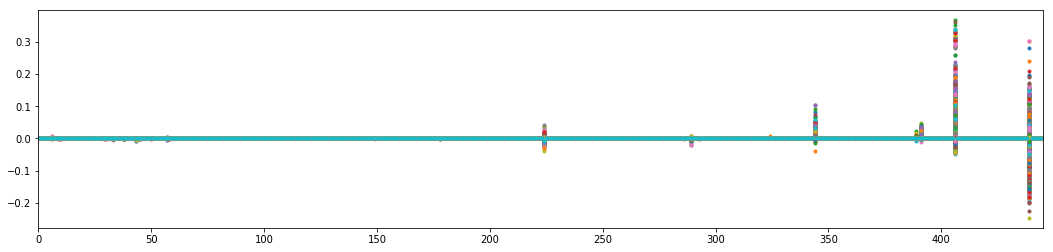

In [8]:
xaxis = np.arange(avg_a.shape[1])

plt.figure(figsize=(18,4))
for i in np.random.randint(0, avg_a.shape[0], size=500):
    plt.plot(xaxis, avg_a[i, :], '.',label=str(i))
plt.xlim([0, 445])
# plt.legend(loc='best')

Text(0,0.5,u'mbs sequence')

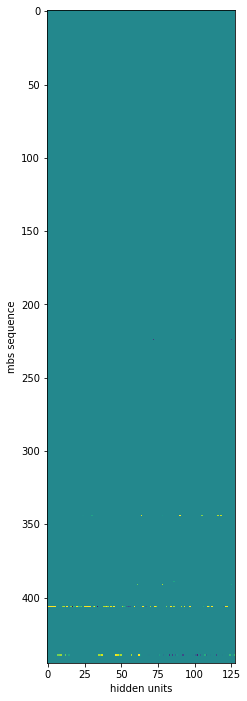

In [9]:
plt.figure(figsize=(10, 12))
plt.imshow(a[1, :, :])
plt.xlabel('hidden units')
plt.ylabel('mbs sequence')

Text(0,0.5,u'mbs sequence')

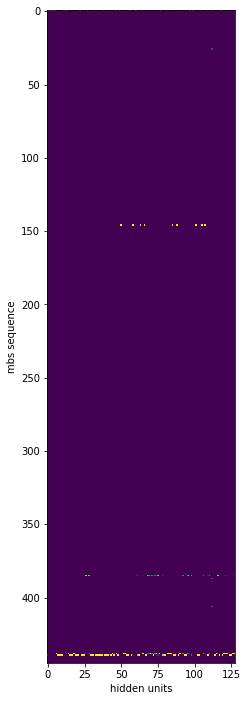

In [74]:
plt.figure(figsize=(10, 12))
plt.imshow(a[2, :, :])
plt.xlabel('hidden units')
plt.ylabel('mbs sequence')